# NLP Practical example: Simple Sentiment Analysis model 

Let's build a complete sentiment analysis system from scratch! We'll classify movie reviews as positive or negative.

In [1]:
import re
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import os
import kagglehub

/Users/ivelindzhangarov/Development/Learning/ML-progressbg/HomeWork/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Data Preparation

For this example, we'll create a small dataset.

In practice, you'd use datasets like [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [ ]:
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

data_path = os.path.join(path, "IMDB Dataset.csv")

df = pd.read_csv(data_path)

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 606-607: invalid continuation byte

In [ ]:
df.head()

,review,sentiment
0,This movie was excellent! I loved every minute...,1
1,Amazing film with great acting and storyline.,1
2,Absolutely fantastic! Best movie I've seen thi...,1
3,Wonderful performances and beautiful cinematog...,1
4,I really enjoyed this movie. Highly recommend!,1


### Data Exaploration

In [5]:
df.shape

(30, 2)

In [6]:
# check sentiment distribution
df['sentiment'].value_counts()

sentiment
1    15
0    15
Name: count, dtype: int64

In [7]:
# check for missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

## Step 2: Text Preprocessing

In [8]:
# Run this cell only once to download NLTK resources
nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ivelindzhangarov/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ivelindzhangarov/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivelindzhangarov/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivelindzhangarov/nltk_data...


True

In [9]:
def preprocess_text(text):
    """
    Complete text preprocessing pipeline

    Args:
        text (str): Raw text input

    Returns:
        str: Cleaned and processed text
    """
    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Tokenize into words
    tokens = word_tokenize(text)

    # 4. Remove stopwords (but keep negations!)
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'neither', 'never'}
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization (reduce words to base form)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 6. Join tokens back into string
    return ' '.join(tokens)

# Apply preprocessing to the reviews
df['cleaned_review'] = df['review'].apply(preprocess_text)
df.head()

,review,sentiment,cleaned_review
0,This movie was excellent! I loved every minute...,1,movie excellent loved every minute
1,Amazing film with great acting and storyline.,1,amazing film great acting storyline
2,Absolutely fantastic! Best movie I've seen thi...,1,absolutely fantastic best movie ive seen year
3,Wonderful performances and beautiful cinematog...,1,wonderful performance beautiful cinematography
4,I really enjoyed this movie. Highly recommend!,1,really enjoyed movie highly recommend


## Step 3: Split Data

In [10]:
# Split features and labels
X = df['cleaned_review']
y = df['sentiment']

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 24
Test set size: 6


## Step 4: Vectorization

In [12]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2))

# Fit on training data and transform both sets
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Training matrix shape: {X_train_tfidf.shape}")
print(f"Test matrix shape: {X_test_tfidf.shape}")

Training matrix shape: (24, 100)
Test matrix shape: (6, 100)


## Step 5: Train Model

In [13]:
# Train Logistic Regression classifier
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_tfidf, y_train)

print("Model trained successfully!")

Model trained successfully!


In [14]:
model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Feature Importance Analysis

We can get the most important features from model coeffcients.

Model coefficients are a measure of how much a feature contributes to the classification score.

The most important features are those with the largest absolute coefficients.

- Large Positive Coefficients → Features strongly indicating Positive Sentiment (Class 1).
- Large Negative Coefficients → Features strongly indicating Negative Sentiment (Class 0).

In [15]:
# Get the model coefficients
# We take the first row [0] because it's a binary classification problem.
coefficients = model.coef_[0]

# Create a Series to map coefficients to feature names
feature_names = vectorizer.get_feature_names_out()
coef_df = pd.Series(coefficients, index=feature_names)

In [16]:
## Top 10 Features Indicating POSITIVE Sentiment
print("--- Top 10 Features for POSITIVE Sentiment (Highest Coefficients) ---")
# .nlargest(10) gets the largest positive coefficients
top_positive = coef_df.nlargest(10)
print(top_positive)

print("\n" + "="*50 + "\n")

## Top 10 Features Indicating NEGATIVE Sentiment
print("--- Top 10 Features for NEGATIVE Sentiment (Lowest Coefficients) ---")
# .nsmallest(10) gets the largest negative coefficients
top_negative = coef_df.nsmallest(10)
print(top_negative)

--- Top 10 Features for POSITIVE Sentiment (Highest Coefficients) ---
great                  0.432521
loved                  0.342525
highly                 0.298342
plot engaging          0.244756
storyline              0.243970
brilliant mustwatch    0.230974
mustwatch              0.230974
mustwatch everyone     0.230974
team                   0.230974
work                   0.230974
dtype: float64


--- Top 10 Features for NEGATIVE Sentiment (Lowest Coefficients) ---
money                -0.433654
horrible             -0.370905
boring               -0.339030
complete             -0.280778
terrible             -0.250467
time                 -0.250467
waste                -0.250467
boring predictable   -0.233510
predictable          -0.233510
absolutely           -0.223675
dtype: float64


## Evaluate Model

In [17]:
# Make predictions to evaluate the model
y_pred = model.predict(X_test_tfidf)

### Calculate accuracy

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4%}")


Accuracy: 33.3333%


### Detailed classification report

The report provides four main metrics for each class: Precision, Recall, F1-Score, and Support.

1. Precision

Precision measures the proportion of a model's positive predictions that are correct, calculated as \(TruePositives/(TruePositives+FalsePositives)\)
- The ability of the classifier not to label as positive a sample that is negative. In simple terms, out of all the instances the model predicted as a certain class (e.g., 'Negative'), how many were actually correct?

2. Recall (or Sensitivity)

- The ability of the classifier to find all the positive samples. In simple terms, out of all the instances that truly belong to a certain class (e.g., 'Negative'), how many did the model correctly identify?

In [19]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.33      0.33      0.33         3
    Positive       0.33      0.33      0.33         3

    accuracy                           0.33         6
   macro avg       0.33      0.33      0.33         6
weighted avg       0.33      0.33      0.33         6



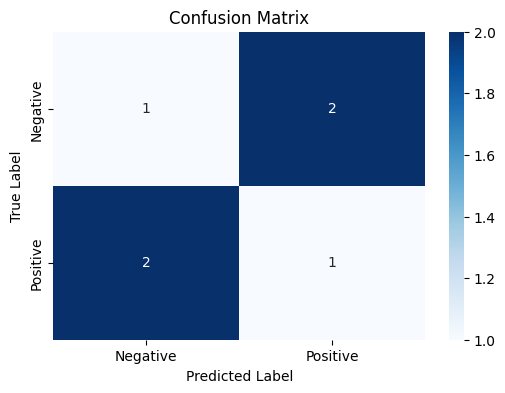

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()